In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 讀取數據檔案
file_path = "C:/python/CTA/成發輔助資料/台指近月期貨指數.csv"
df = pd.read_csv(file_path, encoding='utf-8')
df

,日期,期貨名稱,簡稱,開盤價,最高價,最低價,收盤價,報酬率,成交張數(量),未平倉合約數,基差,未沖銷契約數(合計)
0,1998-07-21,ZTXA,台指近月期貨指數,8131.0,8131.0,8036.0,8045.0,NaN,208,137,-95.80,140
1,1998-07-22,ZTXA,台指近月期貨指數,7950.0,7950.0,7820.0,7870.0,-0.021753,360,279,11.06,288
2,1998-07-23,ZTXA,台指近月期貨指數,7830.0,7859.0,7802.0,7825.0,-0.005718,190,357,54.89,371
3,1998-07-24,ZTXA,台指近月期貨指數,7750.0,7835.0,7740.0,7835.0,0.001278,340,420,67.40,443
4,1998-07-27,ZTXA,台指近月期貨指數,7830.0,7835.0,7780.0,7786.0,-0.006254,150,466,104.30,493
...,...,...,...,...,...,...,...,...,...,...,...,...
6452,2024-07-02,ZTXA,台指近月期貨指數,22838.0,22993.0,22717.0,22831.0,-0.006872,104985,80084,44.37,87515
6453,2024-07-03,ZTXA,台指近月期貨指數,23073.0,23188.0,22981.0,23185.0,0.015240,83985,82758,-10.57,90412
6454,2024-07-04,ZTXA,台指近月期貨指數,23487.0,23626.0,23461.0,23624.0,0.018893,88198,83790,-98.47,91806
6455,2024-07-05,ZTXA,台指近月期貨指數,23659.0,23677.0,23526.0,23570.0,-0.002117,60596,82017,-14.41,90567


In [3]:
df['super_short_mavg'] = df['收盤價'].rolling(5).mean()
df['short_mavg'] = df['收盤價'].rolling(20).mean()
df['long_mavg'] = df['收盤價'].rolling(50).mean()

df = df.drop(['簡稱','開盤價','成交張數(量)','報酬率','基差','未沖銷契約數(合計)'], axis=1)
df = df.rename(columns={'最高價': 'High', '最低價': 'Low','收盤價':'Close'})
df.head()

,日期,期貨名稱,High,Low,Close,未平倉合約數,super_short_mavg,short_mavg,long_mavg
0,1998-07-21,ZTXA,8131.0,8036.0,8045.0,137,NaN,NaN,NaN
1,1998-07-22,ZTXA,7950.0,7820.0,7870.0,279,NaN,NaN,NaN
2,1998-07-23,ZTXA,7859.0,7802.0,7825.0,357,NaN,NaN,NaN
3,1998-07-24,ZTXA,7835.0,7740.0,7835.0,420,NaN,NaN,NaN
4,1998-07-27,ZTXA,7835.0,7780.0,7786.0,466,7872.2,NaN,NaN


In [4]:
fund = 10000

position = None

Buy_and_Hold = []
Sell_and_Short = []

Buy_Stock = []
Sell_Stock = []

profit_list = []

executesize = 0
total_revenue = 0
cumulative_profit = []
cumulative_profit_dates = []  # 日期列表

# 初始化一個空的list來存儲交易記錄
trading_records = []

for i in range(len(df)):
    if i == len(df) - 1:
        break

    if position is None:
        profit_list.append(0)

        if df['super_short_mavg'].iloc[i] > df['short_mavg'].iloc[i] > df['long_mavg'].iloc[i]:
            executesize = fund // df["High"].iloc[i+1]
            position = 'Buy_and_Hold'
            Buy_Stock.append(i+1)
            Buy_and_Hold.append(i+1)
            continue

        if df['super_short_mavg'].iloc[i] < df['short_mavg'].iloc[i] < df['long_mavg'].iloc[i]:
            executesize = fund // df["Low"].iloc[i+1]
            position = 'Sell_and_Short'
            Sell_Stock.append(i+1)
            Sell_and_Short.append(i+1)
            continue

    elif position == 'Buy_and_Hold':
        profit = executesize * (df['Close'].iloc[i+1] - df['Close'].iloc[i])
        total_revenue = total_revenue + profit

        if fund + profit > 0:  # 檢查資金是否會變動
            fund = fund + profit

            # 將交易記錄添加到list中
            trading_records.append({'日期': df.index[i],
                                    'Profit': fund,
                                    '策略損益(金額)': profit})
        else:
            position = None

        if df['super_short_mavg'].iloc[i] < df['short_mavg'].iloc[i] < df['long_mavg'].iloc[i] or i == len(df) - 2:
            profit = executesize * (df['Close'].iloc[i+1] - df['Close'].iloc[i])
            total_revenue = total_revenue + profit

            if fund + profit > 0:  # 檢查資金是否會變動
                fund = fund + profit

                # 將交易記錄添加到list中
                trading_records.append({'日期': df.index[i+1],
                                        'Profit': fund,
                                        '策略損益(金額)': profit})

            Sell_Stock.append(i)
            position = None

    elif position == 'Sell_and_Short':
        profit = executesize * (df['Close'].iloc[i] - df['Close'].iloc[i+1])
        total_revenue = total_revenue + profit

        if fund + profit > 0:  # 檢查資金是否會變動
            fund = fund + profit

            # 將交易記錄添加到list中
            trading_records.append({'日期': df.index[i],
                                    'Profit': fund,
                                    '策略損益(金額)': profit})
        else:
            position = None

        if df['super_short_mavg'].iloc[i] > df['short_mavg'].iloc[i] > df['long_mavg'].iloc[i] or i == len(df) - 2:
            profit = executesize * (df['Close'].iloc[i] - df['Close'].iloc[i+1])
            total_revenue = total_revenue + profit

            if fund + profit > 0:  # 檢查資金是否會變動
                fund = fund + profit

                # 將交易記錄添加到list中
                trading_records.append({'日期': df.index[i+1],
                                        'Profit': fund,
                                        '策略損益(金額)': profit})

            Buy_Stock.append(i)
            position = None

    if i in Buy_Stock or i in Sell_Stock:  # 檢查日期是否存在於交易點
        cumulative_profit_dates.append(df.index[i])  # 添加日期到列表中
        cumulative_profit.append(total_revenue)


In [5]:
# 如果有交易記錄，則將交易記錄保存為DataFrame並保存為CSV文件
if trading_records:
    # 將交易記錄保存為DataFrame
    trading_df = pd.DataFrame(trading_records)

    # 將DataFrame保存為CSV文件
    trading_df.to_csv('均線交叉交易紀錄.csv', index=False,encoding='utf-8-sig')

In [6]:
print("Total Profit/Loss:", total_revenue)
print("Buy Points:", Buy_Stock)
print("Sell Points:", Sell_Stock)
print("Buy and Hold Points:", Buy_and_Hold)
print("Sell and Short Points:", Sell_and_Short)

Total Profit/Loss: 17661.0
Buy Points: [73, 75, 170, 172, 302, 304, 363, 365, 462, 510, 512, 676, 678, 869, 871, 1115, 1117, 1166, 1168, 1225, 1227, 1256, 1258, 1409, 1411, 1478, 1480, 1569, 1571, 1640, 1642, 1685, 1687, 1750, 1752, 1873, 1875, 1966, 1968, 2054, 2056, 2209, 2211, 2327, 2329, 2434, 2436, 2645, 2647, 2683, 2685, 2949, 2951, 3023, 3025, 3214, 3216, 3350, 3352, 3404, 3406, 3543, 3545, 3628, 3630, 3721, 3723, 3781, 3783, 3816, 3818, 3876, 3878, 4057, 4108, 4110, 4318, 4320, 4413, 4415, 4486, 4488, 4612, 4614, 4880, 4882, 4935, 4937, 4968, 4970, 5014, 5016, 5137, 5139, 5237, 5239, 5288, 5290, 5437, 5439, 5557, 5559, 5711, 5713, 5813, 5815, 5999, 6001, 6067, 6069, 6182, 6184, 6303, 6305]
Sell Points: [57, 119, 121, 275, 277, 328, 330, 441, 443, 474, 522, 524, 721, 723, 990, 992, 1152, 1154, 1188, 1190, 1229, 1234, 1383, 1385, 1462, 1464, 1483, 1485, 1610, 1612, 1672, 1674, 1713, 1715, 1811, 1813, 1939, 1941, 2003, 2005, 2185, 2187, 2301, 2303, 2363, 2365, 2500, 2502, 2664, 26

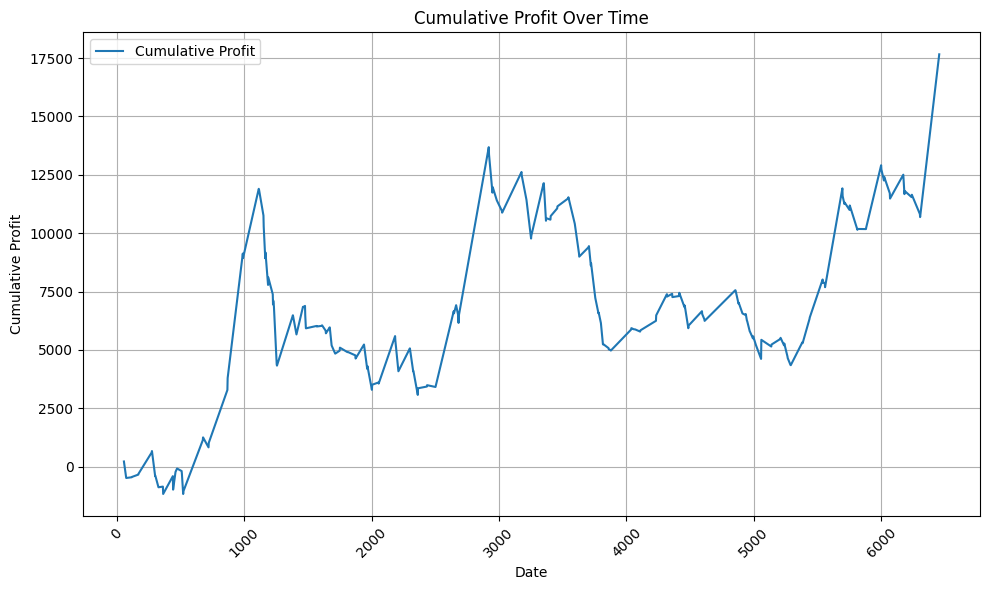

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_profit_dates, cumulative_profit, label='Cumulative Profit')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()